<a href="https://colab.research.google.com/github/hanggao811/AnomalyDetectionLIGO/blob/main/AE_simplest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [128]:
# Imports
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import BatchNormalization, Input
from matplotlib import pyplot as plt
from sklearn import metrics
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
import glob, re
from sklearn.base import BaseEstimator, RegressorMixin
from tensorflow.keras.models import load_model as keras_load_model
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.signal import welch, csd, coherence, stft
# Set random seed
import random
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
# Mount to googlecolab
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/dataset')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [129]:
# Load data and normalize it
background_train = np.load('background_train.npy')
stds_train = np.std(background_train, axis=-1)[:, :, np.newaxis]
background_train = background_train/stds_train
background_train = np.swapaxes(background_train, 1, 2)

background_test = np.load('background_test.npy')
stds_test = np.std(background_test, axis=-1)[:, :, np.newaxis]
background_test = background_test/stds_test
background_test = np.swapaxes(background_test, 1, 2)

bbh_train = np.load('bbh_train.npy')
stds_train = np.std(bbh_train, axis=-1)[:, :, np.newaxis]
bbh_train = bbh_train/stds_train
bbh_train = np.swapaxes(bbh_train, 1, 2)

bbh_test = np.load('bbh_test.npy')
stds_test = np.std(bbh_test, axis=-1)[:, :, np.newaxis]
bbh_test = bbh_test/stds_test
bbh_test = np.swapaxes(bbh_test, 1, 2)

sglf_train = np.load('sglf_train.npy')
stds_train = np.std(sglf_train, axis=-1)[:, :, np.newaxis]
sglf_train = sglf_train/stds_train
sglf_train = np.swapaxes(sglf_train, 1, 2)

sglf_test = np.load('sglf_test.npy')
stds_test = np.std(sglf_test, axis=-1)[:, :, np.newaxis]
sglf_test = sglf_test/stds_test
sglf_test = np.swapaxes(sglf_test, 1, 2)

# Load test data and normalize them
data = np.load('ligo_bb_final.npz')
test_data = data['data']
stds = np.std(test_data, axis=-1)[:, :, np.newaxis]
test_data = test_data/stds
test_data = np.swapaxes(test_data, 1, 2)

data_label = data['ids']
indices1 = np.where(data_label == 1)[0]
indices0 = np.where(data_label == 0)[0]
background_test_data = test_data[indices0]
signal_test_data = test_data[indices1]

In [130]:
print('shape for background train/test' , background_train.shape, background_test.shape)
print('shape for bbh train/test' , bbh_train.shape, bbh_test.shape)
print('shape for sglf train/test' , sglf_train.shape, sglf_test.shape)
print('shape for test bg/test data' , background_test_data.shape, signal_test_data.shape)

shape for background train/test (80000, 200, 2) (20000, 200, 2)
shape for bbh train/test (80000, 200, 2) (20000, 200, 2)
shape for sglf train/test (80000, 200, 2) (20000, 200, 2)
shape for test bg/test data (50000, 200, 2) (10000, 200, 2)


In [131]:
# Making correlation
def add_correlation_channel(x):
    x1, x2 = x[:, :, 0], x[:, :, 1]
    corr = np.array([
        np.correlate(x1[i], x2[i], mode='same') for i in range(x.shape[0])
    ])
    return np.stack([x1, x2, corr], axis=-1)

background_train = add_correlation_channel(background_train)
background_test = add_correlation_channel(background_test)
bbh_train = add_correlation_channel(bbh_train)
bbh_test = add_correlation_channel(bbh_test)
sglf_train = add_correlation_channel(sglf_train)
sglf_test = add_correlation_channel(sglf_test)
background_test_data = add_correlation_channel(background_test_data)
signal_test_data = add_correlation_channel(signal_test_data)


In [132]:
# Add Psd channel using Welch with shape (N_samples, 101)
fs = 4096
##--background_psd--##
_,bg_train_psd = csd(background_train[:,:,0], background_train[:,:,1], fs=fs, nperseg=200)
_,bg_test_psd = csd(background_test[:,:,0], background_test[:,:,1], fs=fs, nperseg=200)
bg_train_psd = abs(bg_train_psd)
bg_test_psd = abs(bg_test_psd)
##--bbh_psd--##
_,bbh_train_psd = csd(bbh_train[:,:,0], bbh_train[:,:,1], fs=fs, nperseg=200)
_,bbh_test_psd = csd(bbh_test[:,:,0],bbh_test[:,:,1], fs=fs, nperseg=200)
bbh_train_psd = abs(bbh_train_psd)
bbh_test_psd = abs(bbh_test_psd)
##--sglf_psd--##
_,sglf_train_psd = csd(sglf_train[:,:,0], sglf_train[:,:,1], fs=fs, nperseg=200)
_,sglf_test_psd = csd(sglf_test[:,:,0],sglf_test[:,:,1],fs=fs,nperseg=200)
sglf_train_psd = abs(sglf_train_psd)
sglf_test_psd = abs(sglf_test_psd)
##--signal_test_dat_psd--##
_,signal_test_data_psd = csd(signal_test_data[:,:,0],signal_test_data[:,:,1],fs=fs,nperseg=200)
_,background_test_data_psd = csd(background_test_data[:,:,0],background_test_data[:,:,1],fs=fs,nperseg=200)
signal_test_data_psd = abs(signal_test_data_psd)
background_test_data_psd = abs(background_test_data_psd)



# Add Psd channel using Welch with shape (N_samples, 101)
fs = 4096
##--background_psd--##
f,t,bg_train_stft = stft(background_train[:,:,0] , fs=fs, nperseg=10)
# bg_train_stft = abs(bg_train_stft)
f,t,bg_test_stft = stft(background_test[:,:,0], fs=fs, nperseg=10)
# bg_test_stft = abs(bg_test_stft)
##--bbh_psd--##
f,t,bbh_train_stft = stft(bbh_train[:,:,0], fs=fs, nperseg=10)
bbh_train_stft = abs(bbh_train_stft)
f,t,bbh_test_stft = stft(bbh_test[:,:,0], fs=fs, nperseg=10)
bbh_test_stft = abs(bbh_test_stft)

##--sglf_psd--##
f,t,sglf_train_stft = stft(sglf_train[:,:,0], fs=fs, nperseg=10)
sglf_train_stft = abs(sglf_train_stft)
f,t,sglf_test_stft = stft(sglf_test[:,:,0], fs=fs, nperseg=10)
sglf_test_stft = abs(sglf_test_stft)

##--signal_test_dat_psd--##
f,t,signal_test_data_stft = stft(signal_test_data[:,:,0],fs=fs,nperseg=10)
# signal_test_data_stft = abs(signal_test_data_stft)
f,t,background_test_data_stft = stft(background_test_data[:,:,0],fs=fs,nperseg=10)
# background_test_data_stft = abs(background_test_data_stft)


In [133]:
# sample = np.abs(bg_train_stft[-3])  # shape (freqs, time)
# plt.pcolormesh(t, f, np.log10(sample + 1e-12), shading='gouraud')

# # Then plot
# plt.pcolormesh(t, f, sample, shading='gouraud')
# plt.colorbar(label="|Zx * conj(Zy)|")
# plt.ylabel("Frequency [Hz]")
# plt.xlabel("Time [s]")
# plt.title("Cross STFT Magnitude")
# plt.tight_layout()
# plt.show()

SOLUTION GIVEN

In [134]:
tf.config.experimental.enable_op_determinism()

class Autoencoder:
    def __init__(self, input_shape=(200,3),stft_shape=(6,41), dropout=0.1, batch_size = 256, epochs = 50, lr = 1e-3,
                 f1=3,f2=16,f3=32,f4=64,k1=16,k2=32,k3=64,k4=128,s1=2,s2=2,s3=1,s4=1):
        super().__init__()
        self.input_shape = input_shape
        self.stft_shape = stft_shape
        self.f1 = f1
        self.f2 = f2
        self.f3 = f3
        self.k1 = k1
        self.k2 = k2
        self.k3 = k3
        self.s1 = s1
        self.s2 = s2
        self.s3 = s3
        self.f4 = f4
        self.k4 = k4
        self.s4 = s4
        self.dropout = dropout
        self.batch_size = batch_size
        self.epochs = epochs
        self.lr = lr
        self.model_ = None

    def positional_encoding(self, inputs):
        embed_size = inputs.shape[-1]
        input_length = inputs.shape[-2]
        assert embed_size % 2 == 0, 'embed_size must be even'
        p, i = np.meshgrid(np.arange(input_length), np.arange(embed_size // 2))
        pos_emb = np.empty((1,input_length, embed_size))
        pos_emb[0,:,::2] = np.sin(p/(10000**(2*i/embed_size))).T
        pos_emb[0,:,1::2] = np.cos(p/(10000**(2*i/embed_size))).T
        self.pos_encoding = tf.constant(pos_emb.astype(np.float32))
        return inputs + self.pos_encoding[:, :input_length, :]

    def build_model(self):
        inputs = keras.Input(shape=self.input_shape)
        x = inputs

        # Encoder
        print('Encoder layer shape')
        x = layers.Conv1D(filters=self.f1, kernel_size=self.k1, strides=self.s1, padding="same", activation="tanh")(x)
        print(x.shape)
        x = layers.Dropout(rate=self.dropout)(x)
        x = layers.Conv1D(filters=self.f2, kernel_size=self.k2, strides=self.s2, padding="same")(x)
        print(x.shape)
        x = layers.Conv1D(filters=self.f3, kernel_size=self.k3, strides=self.s3, padding="same")(x)
        print(x.shape)

        # Bottleneck
        print("Bottleneck shape")
        latent_x = layers.Conv1D(filters=self.f4, kernel_size=self.k4, strides=self.s4, padding="same")(x)
        print(latent_x.shape)
        x = layers.Dropout(rate=self.dropout)(latent_x)

        # Decoder Head
        print("Decoder layer shape")
        x = layers.Conv1DTranspose(filters=self.f3, kernel_size=self.k3, strides=self.s3, padding="same")(x)
        print(x.shape)
        x = layers.Conv1DTranspose(filters=self.f2, kernel_size=self.k2, strides=self.s2, padding="same")(x)
        print(x.shape)
        decoder_output = layers.Conv1DTranspose(filters=self.f1, kernel_size=self.k1, strides=1, padding="same")(x)
        print(decoder_output.shape)

        # STFT Head
        print("STFT layer shape")
        stft_x = layers.Flatten()(latent_x)
        print(stft_x.shape)
        stft_x = layers.Dense(self.stft_shape[0]*self.stft_shape[1])(stft_x)
        print(stft_x.shape)
        stft_x = layers.Reshape((self.stft_shape[0],self.stft_shape[1]))(stft_x)
        print(stft_x.shape)
        stft_output = layers.Conv1D(filters=self.stft_shape[1], kernel_size=1, strides=1, padding="same")(stft_x)
        print(stft_output.shape)


        self.model_ = keras.Model(inputs, outputs={"reconstructed_signal": decoder_output, "predicted_stft": stft_output })
        self.model_.compile(loss={"reconstructed_signal": "mse","predicted_stft": "mse"},
                            loss_weights={"reconstructed_signal": 1,"predicted_stft": 0.3},
                            optimizer=keras.optimizers.Adam(learning_rate=self.lr))


    def predict(self, X):
        return self.model_.predict(X, batch_size=self.batch_size)


In [135]:
param_set = [
    {'batch_size': 256, 'dropout': 0.1, 'epochs': 50, 'f1': 32, 'f2': 16, 'f5': 3, 'k1': 16,  'k2': 32, 'k3': 64, 'k4': 128,  'k5': 5,  'lr': 0.001, 's1': 2, 's2': 2}, #0.978,0.984,0.280, before that(no correlation) 0.658,0.413,0.348
    #same feature but adding one more layer at the beginnning to make it symmetry without correlation #(None, 200, 32) (None, 100, 32) (None, 50, 16) (None, 100, 16) (None, 200, 32) (None, 200, 2)  0.942 0.968 0.346 no correlation gives 0.799 0.404 0.322
    #its not perfectly symmetric, let me try this
    {'batch_size': 256, 'dropout': 0.1, 'epochs': 50, 'f1': 3, 'f2': 8, 'f3': 32, 'f4':128, 'k1': 4,  'k2':8 , 'k3': 16, 'k4':32, 'lr': 0.001, 's1': 1, 's2': 2, 's3':2, 's4':1}


]
params = param_set[1]
AE = Autoencoder(input_shape=(200, 3),stft_shape=bg_train_stft.shape[1:], **params)
AE.build_model()
AE.model_.fit(background_train,{"reconstructed_signal":background_train,"predicted_stft":bg_train_stft},epochs=AE.epochs,batch_size=AE.batch_size,validation_split=0.2,verbose=1,callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])

Encoder layer shape
(None, 200, 3)
(None, 100, 8)
(None, 50, 32)
Bottleneck shape
(None, 50, 128)
Decoder layer shape
(None, 100, 32)
(None, 200, 8)
(None, 200, 3)
STFT layer shape
(None, 6400)
(None, 246)
(None, 6, 41)
(None, 6, 41)
Epoch 1/50


250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 34.8408 - predicted_stft_loss: 0.1237 - reconstructed_signal_loss: 34.8037

250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 34.7928 - predicted_stft_loss: 0.1236 - reconstructed_signal_loss: 34.7557 - val_loss: 11.1108 - val_predicted_stft_loss: 0.0928 - val_reconstructed_signal_loss: 11.0851
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 12.2364 - predicted_stft_loss: 0.0913 - reconstructed_signal_loss: 12.2090 - val_loss: 3.3448 - val_predicted_stft_loss: 0.0895 - val_reconstructed_signal_loss: 3.3186
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 5.9860 - predicted_stft_loss: 0.0893 - reconstructed_signal_loss: 5.9592 - val_loss: 2.2337 - val_predicted_stft_loss: 0.0894 - val_reconstructed_signal_loss: 2.2074
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 5.5638 - predicted_stft_loss: 0.0893 - reconstructed_signal_loss: 5.5370 - val_loss: 2.0656 - val_predicted_stft_loss: 0.0895 - val_reconstructed_signal_loss: 2.0391
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 4.6532 - predicted_stft_loss: 0.08

In [136]:
signal_test_data_stft

array([[[-0.11037654+0.00000000e+00j,  0.45128176+0.00000000e+00j,
          0.10852316+0.00000000e+00j, ..., -0.07021052+0.00000000e+00j,
         -0.17115874+0.00000000e+00j, -0.03557257+0.00000000e+00j],
        [ 0.06036347-1.12520473e-01j, -0.40033147+3.19583981e-01j,
          0.04136127-3.72891344e-03j, ..., -0.17290788-3.19168458e-01j,
         -0.14151257+5.57697707e-01j,  0.04260226+2.89068788e-02j],
        [-0.00156938+1.88318343e-01j,  0.27019451-4.63764357e-01j,
         -0.1381098 -6.41920574e-02j, ...,  0.18362365-6.43892272e-02j,
          0.61747953-5.19461905e-01j,  0.01362232-5.96302955e-02j],
        [-0.15606293-2.54290840e-01j, -0.23802437+5.54386920e-01j,
          0.23666217+3.09773006e-02j, ...,  0.27003384+8.88470667e-02j,
         -0.59503013+1.70700522e-02j, -0.04565937-4.79131362e-05j],
        [ 0.31187181+1.31637328e-01j,  0.17491353-3.49024921e-01j,
         -0.24214617-5.23990470e-02j, ..., -0.28036207+1.36302873e-01j,
          0.22894634+2.09438092e-

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


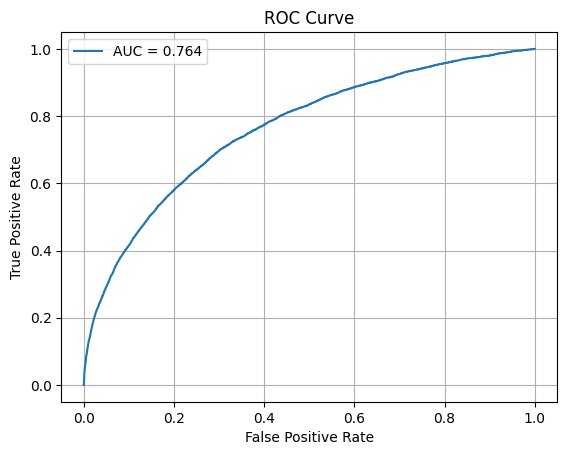

In [137]:
test_pred = AE.predict(signal_test_data)['predicted_stft']
bg_pred = AE.predict(background_test_data)['predicted_stft']
test_mse = np.mean((test_pred - abs(signal_test_data_stft))**2,axis=(1,2))
bg_mse = np.mean((bg_pred - abs(background_test_data_stft))**2,axis=(1,2))
test_result = np.concatenate([bg_mse,test_mse])
true = np.concatenate([np.zeros(bg_pred.shape[0]),np.ones(test_pred.shape[0])])
# print(min(test_mse),max(test_mse),np.mean(test_mse))
# print(min(bg_mse),max(bg_mse),np.mean(bg_mse))

fpr, tpr, thresholds = roc_curve(true, test_result)
auc_sg = roc_auc_score(true, test_result)
plt.plot(fpr, tpr,label=f'AUC = {auc_sg:.3f}')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.grid(True)
plt.legend()
plt.show()

In [138]:
bg_mse

array([0.16235432, 0.16863161, 0.15032285, ..., 0.16232029, 0.15762365,
       0.15868848])

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
0.14249633716457058 0.29301462247469423 0.18384119633526147
0.1419612379156429 0.2880881649160666 0.1702899320979886


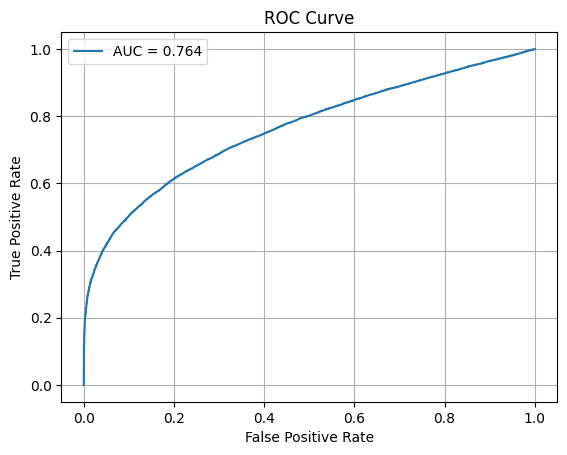

In [139]:
bbh_pred = AE.predict(bbh_test)['predicted_stft']
bg_pred = AE.predict(background_test)['predicted_stft']
bbh_mse = np.mean((bbh_pred - abs(bbh_test_stft))**2, axis=(1,2))
bg_mse = np.mean((bg_pred - abs(bg_test_stft))**2, axis=(1,2))
test_result = np.concatenate([bg_mse,bbh_mse])
true = np.concatenate([np.zeros(bg_pred.shape[0]),np.ones(bbh_pred.shape[0])])
print(min(bbh_mse),max(bbh_mse),np.mean(bbh_mse))
print(min(bg_mse),max(bg_mse),np.mean(bg_mse))

fpr, tpr, thresholds = roc_curve(true, test_result)
auc_bbh = roc_auc_score(true, test_result)
plt.plot(fpr, tpr,label=f'AUC = {auc_bbh:.3f}')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.grid(True)
plt.legend()
plt.show()

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
0.12607049339002202 0.30869472528518 0.18253398267750512
0.1419612379156429 0.2880881649160666 0.1702899320979886


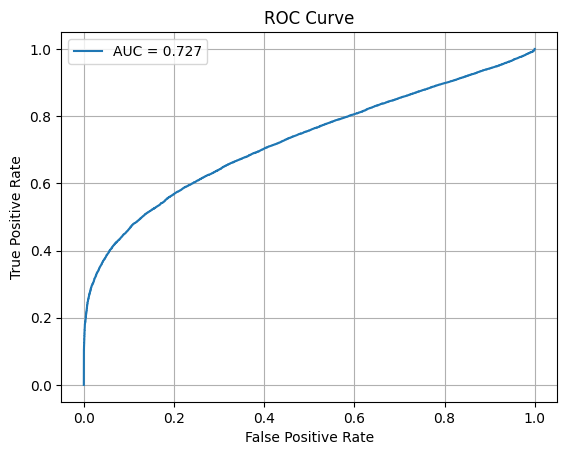

In [140]:
sglf_pred = AE.predict(sglf_test)['predicted_stft']
sglf_mse = np.mean((sglf_pred - abs(sglf_test_stft))**2, axis=(1,2))
test_result = np.concatenate([bg_mse,sglf_mse])
true = np.concatenate([np.zeros(bg_pred.shape[0]),np.ones(sglf_pred.shape[0])])
print(min(sglf_mse),max(sglf_mse),np.mean(sglf_mse))
print(min(bg_mse),max(bg_mse),np.mean(bg_mse))

fpr, tpr, thresholds = roc_curve(true, test_result)
auc_sglf = roc_auc_score(true, test_result)
plt.plot(fpr, tpr,label=f'AUC = {auc_sglf:.3f}')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.grid(True)
plt.legend()
plt.show()

In [141]:
# save_dir = '/content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_save'

# param_set = [
#     {'batch_size': 256, 'dropout': 0.1, 'epochs': 50, 'f1': 61, 'f2': 22, 'f5': 2, 'k1': 9,  'k2': 15, 'k3': 24, 'k4': 4,  'k5': 6,  'lr': 0.001, 's1': 1, 's2': 2},
#     {'batch_size': 256, 'dropout': 0.1, 'epochs': 50, 'f1': 52, 'f2': 29, 'f5': 2, 'k1': 16, 'k2': 6,  'k3': 8,  'k4': 25, 'k5': 4,  'lr': 0.001, 's1': 1, 's2': 2},
#     {'batch_size': 256, 'dropout': 0.1, 'epochs': 50, 'f1': 36, 'f2': 29, 'f5': 2, 'k1': 7,  'k2': 14, 'k3': 15, 'k4': 7,  'k5': 3,  'lr': 0.001, 's1': 1, 's2': 2},
#     {'batch_size': 256, 'dropout': 0.1, 'epochs': 50, 'f1': 60, 'f2': 21, 'f5': 2, 'k1': 10, 'k2': 34, 'k3': 26, 'k4': 3,  'k5': 8,  'lr': 0.001, 's1': 1, 's2': 1},
#     {'batch_size': 256, 'dropout': 0.1, 'epochs': 50, 'f1': 38, 'f2': 28, 'f5': 2, 'k1': 22, 'k2': 21, 'k3': 27, 'k4': 31, 'k5': 8,  'lr': 0.001, 's1': 1, 's2': 2},
#     {'batch_size': 256, 'dropout': 0.1, 'epochs': 50, 'f1': 40, 'f2': 14, 'f5': 2, 'k1': 4,  'k2': 8,  'k3': 20, 'k4': 29, 'k5': 8,  'lr': 0.001, 's1': 1, 's2': 1},
#     {'batch_size': 256, 'dropout': 0.1, 'epochs': 50, 'f1': 62, 'f2': 16, 'f5': 2, 'k1': 4,  'k2': 14, 'k3': 37, 'k4': 34, 'k5': 5,  'lr': 0.001, 's1': 1, 's2': 2}
# ]

# for i, params in enumerate(param_set):
#     autoencoder = Autoencoder(**params, input_shape=(200, 2))
#     autoencoder.build_model()
#     autoencoder.model_.fit(
#         x_train, x_train,
#         epochs=params['epochs'],
#         batch_size=params['batch_size'],
#         verbose=1,
#         callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
#     )
#     autoencoder.model_.save(f"/content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_save/model_{i}.keras")
#     print(f"✅ Saved model_{i}.keras")

In [142]:
# def eval(model, bg, anomaly):
#     bg_pred = model.predict(bg)
#     anomaly_pred = model.predict(anomaly)
#     bg_mse = np.mean((bg_pred - bg)**2, axis=(1,2))
#     anomaly_mse = np.mean((anomaly_pred - anomaly)**2, axis=(1,2))

#     true_val = np.concatenate((np.zeros(bg.shape[0]),np.ones(anomaly.shape[0])))
#     pred_val = np.concatenate((bg_mse, anomaly_mse))

#     fpr, tpr, thresholds = roc_curve(true_val, pred_val)
#     auc_score = auc(fpr, tpr)
#     return auc_score

# # def eval(model, bg, anomaly):
# #     bg_pred = model.predict(bg)
# #     anomaly_pred = model.predict(anomaly)

# #     bg_mse = np.mean((bg_pred - bg) ** 2, axis=(1, 2))
# #     anomaly_mse = np.mean((anomaly_pred - anomaly) ** 2, axis=(1, 2))

# #     true_val = np.concatenate((np.zeros(bg.shape[0]), np.ones(anomaly.shape[0])))
# #     pred_val = np.concatenate((bg_mse, anomaly_mse))

# #     auc = roc_auc_score(true_val, pred_val)
# #     return auc

# model_files = glob.glob("/content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_save/model_*.keras")
# model_files = sorted(model_files, key=lambda x: int(re.search(r"model_(\d+).keras", x).group(1)))
# for model_file in model_files:
#     model = keras_load_model(model_file)
#     auc_bbh = eval(model,background_test,bbh_test)
#     auc_sglf = eval(model,background_test,sglf_test)
#     auc_test = eval(model,background_test_data, signal_test_data)
#     print(f"✅ Evaluation of model {model_file}: BBH AUC = {auc_bbh}, SG AUC = {auc_sglf}, Test AUC = {auc_test}")

